In this notebook we are going to visualize some OpenPMD output from simulations performed with AsterX. For further info about OpenPMD, please visit:

- Official website:  https://www.openpmd.org
- GitHub repository: https://github.com/openPMD
- Documentation:     https://openpmd-api.readthedocs.io

Import all the modules needed:

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from celluloid import Camera
import openpmd_api as io

Set the Matplotlib backend to `notebook`, not `inline`, since we'll want to animate some figures and the latter is not compatible with that

In [2]:
%matplotlib notebook

Open a .bp file (ADIOS2 extension) as an OpenPMD **'series'**, which is a collection of **'iterations'**, each of which contains **'records'**, which are sets of either structured data --- **'meshes'** --- or unstructured data --- **'particles'**; AsterX only outputs mesh data. Each record has one or more **'components'**: for example, a record representing a scalar field only has one component, while a record representing a vector field has three.

In [3]:
series = io.Series("/root/simulations/shocktube/output-0000/shocktube/shocktube.it%08T.bp", io.Access.read_only)

All iterations in our series have the same structure --- i.e., they contain
the same records --- since they all represent the same output, just at
different times. Here we define an empty Python nested dictionary whose
structure, once full, will be:

Iteration 0:
- Record 1:
  - Component 1: 3D data array
  - Component 2: 3D data array
  - Component 3: 3D data array
- Record 2:
  - Component 1: 3D data array
  - Component 2: 3D data array
  - Component 3: 3D data array
  
 [...]

Iteration 1:
- Record 1:
  - Component 1: 3D data array
  - Component 2: 3D data array
  - Component 3: 3D data array
- Record 2:
  - Component 1: 3D data array
  - Component 2: 3D data array
  - Component 3: 3D data array
  
 [...]

[...]

In [4]:
iter_rec_comp_dict = {}

Print info, register data chunks and fill the above dictionary:

In [5]:
for index in series.iterations:
    iteration = str(index)

    print("\nIteration " + iteration + ":")
    print("==============")

    # Allocate an empty dictionary associated to this iteration
    iter_rec_comp_dict[iteration] = {}

    i = series.iterations[index]

    for key in i.meshes:
        print("Components of record \"" + key + "\":")

        # Allocate an empty dictionary associated to this record. Notice that
        # 'record' is an OpenPMD mesh object, so it's better to use 'key'
        # instead of 'record' as a key in the dictionary ('record' could also be
        # used, but it makes accessing the key clumsy).
        record = i.meshes[key]
        iter_rec_comp_dict[iteration][key] = {}

        # Load each component of each record as a 'data chunk', i.e., an
        # allocated, but STILL INVALID, NumPy array. Later we will flush all
        # chunks (i.e., basically, fill the NumPy arrays) at once: this leads
        # to better I/O performance compared to flushing a large number of
        # small chunks. That's why we bothered creating the nested dictionary:
        # in this way, we can access the valid NumPy arrays for plotting
        # without having to flush each single chunk.
        # *IMPORTANT*: DO NOT access data chunks until flushing has happened!
        for component in record:
            print("    > " + component)  # 'component' is a string
            iter_rec_comp_dict[iteration][key][component] = record[component].load_chunk()  # *INVALID* 3D NumPy array

        print("")


Iteration 0:
Components of record "carpetx_regrid_error_rl00":
    > carpetx_regrid_error

Components of record "hydrobase_eps_rl00":
    > hydrobase_eps

Components of record "hydrobase_press_rl00":
    > hydrobase_press

Components of record "hydrobase_rho_rl00":
    > hydrobase_rho

Components of record "hydrobase_vel_rl00":
    > hydrobase_velx
    > hydrobase_vely
    > hydrobase_velz


Iteration 10:
Components of record "carpetx_regrid_error_rl00":
    > carpetx_regrid_error

Components of record "hydrobase_eps_rl00":
    > hydrobase_eps

Components of record "hydrobase_press_rl00":
    > hydrobase_press

Components of record "hydrobase_rho_rl00":
    > hydrobase_rho

Components of record "hydrobase_vel_rl00":
    > hydrobase_velx
    > hydrobase_vely
    > hydrobase_velz


Iteration 20:
Components of record "carpetx_regrid_error_rl00":
    > carpetx_regrid_error

Components of record "hydrobase_eps_rl00":
    > hydrobase_eps

Components of record "hydrobase_press_rl00":
    > h

Flush all registered data chunks, which are now **VALID** 3D NumPy arrays:

In [6]:
series.flush()

Visualize a 2D movie of the mass density on an (x, z) slice of the domain

<IPython.core.display.Javascript object>


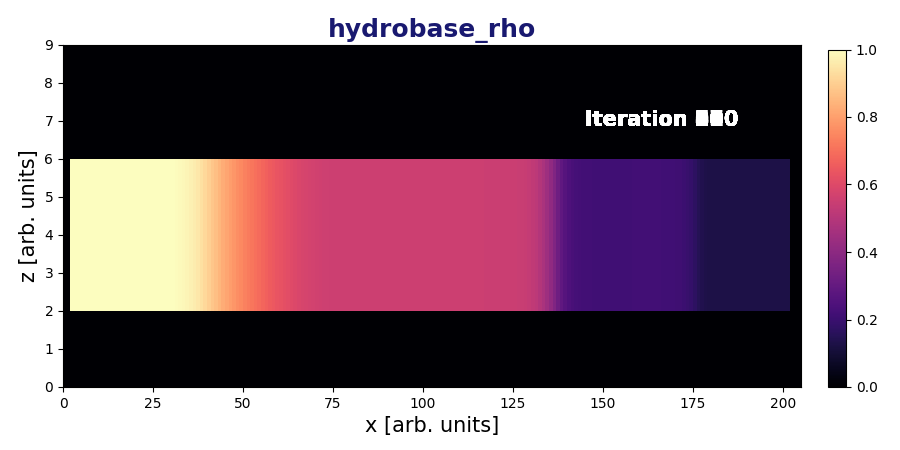

In [9]:
# Select the desired record and component to plot
record    = "hydrobase_rho_rl00"  # "carpetx_regrid_error_rl00", "hydrobase_eps_rl00", "hydrobase_press_rl00", "hydrobase_rho_rl00", "hydrobase_vel_rl00"
component = "hydrobase_rho"  # "carpetx_regrid_error", "hydrobase_eps", "hydrobase_press", "hydrobase_rho", "hydrobase_velx", "hydrobase_vely", "hydrobase_velz"

# Set up the axes for the plot and the colorbar
fig    = plt.figure(figsize = [9., 4.5])
axplot = fig.add_axes([0.07, 0.14, 0.82, 0.76])
axclb  = fig.add_axes([0.92, 0.14, 0.02, 0.75])

# Set title and labels
axplot.set_title(component, fontsize = 18., fontweight = "bold", color = "midnightblue")
axplot.set_xlabel("x [arb. units]", fontsize = 15.)
axplot.set_ylabel("z [arb. units]", fontsize = 15.)

# Initialize the camera
camera = Camera(fig)

# Print frames
for iteration in iter_rec_comp_dict:
    # Retrieve the 3D array containing the data
    array3D = iter_rec_comp_dict[iteration][record][component]
    
    # Plot on the (x, z) plane at the half-way value of y
    # (y index = int(array3D.shape[1]/2) )
    # Notice that the 3D array is stored in (z, y, x) order
    y_index = int(array3D.shape[1]/2)
    image   = axplot.pcolormesh(array3D[:, y_index, :],
                                cmap = "magma", vmin = 0., vmax = 1.)
                                ##vmin = np.min(data_xz), vmax = np.max(data_xz))

    # Set up the colorbar
    fig.colorbar(image, cax = axclb, extend = "neither")
    
    # Print the current iteration
    fig.text(0.65, 0.72, "Iteration " + iteration,
             fontsize = 15., fontweight = "bold", color = "white")

    # Take a snapshot of the figure at this iteration (needed later for the animation)
    camera.snap()

In [8]:
animation = camera.animate()
plt.show()